In [60]:
from copy import deepcopy
import numpy as np 
import wandb
from sklearn.datasets import make_classification
import tensorflow as tf
import wandb

import matplotlib as mpl 
mpl.rcParams['figure.facecolor'] = "white"
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

from templates import AutoDiffFunction, Layer, Loss, Optimizer

# Defining the activation functions

In [2]:
class Sigmoid(AutoDiffFunction):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        self.saved_for_backward = 1/(1 + np.exp(-x))
        return self.saved_for_backward

    def compute_grad(self, x):
        y = self.saved_for_backward

        return {"x": y*(1-y)}

    def backward(self, dy):
        return dy * self.grad["x"]      


class RelU(AutoDiffFunction):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        self.saved_for_backward = np.where(x>0.0, 1.0, 0.0)

        return x * self.saved_for_backward

    def compute_grad(self, x):
        return {"x": self.saved_for_backward}

    def backward(self, dy):
        return dy * self.grad["x"]
     
class Softmax(AutoDiffFunction):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        v = np.exp(x)
        self.saved_for_backward = v

        return v / np.sum(v, axis=1, keepdims=True)

    def compute_grad(self, x):
        pass

    def backward(self, dy):
        return dy * self.grad["x"]

class Tanh(AutoDiffFunction):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        self.saved_for_backward = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

        return self.saved_for_backward

    def compute_grad(self, x):
        y = self.saved_for_backward

        return {"x": 1 - y**2}

    def backward(self, dy):
        return dy * self.grad["x"]

# Defining the layers

In [3]:
class FC(Layer):
    def __init__(self, in_dim, out_dim, weight_decay=None, init_method="random") -> None:
        super().__init__()
        self.weight_decay = weight_decay
        self.init_method = init_method
        self.prev = self.next = None
        self.initialize_weights(in_dim, out_dim)

    def initialize_weights(self, in_dim, out_dim):
        
        if self.init_method == "random":
            scaling_factor = 1/np.sqrt(in_dim)
            self.weights["w"] = np.random.randn(in_dim, out_dim) * scaling_factor
            self.weights["b"] = np.random.randn(1, out_dim) * scaling_factor
        elif self.init_method == "xavier":
            lim = np.sqrt(6 / (in_dim + out_dim))
            self.weights["w"] = np.random.uniform(low=-lim, high=lim, size=(in_dim, out_dim))
            self.weights["b"] = np.random.uniform(low=-lim, high=lim, size=(1, out_dim))

    def compute_grad(self, x):
        
        gradients = {}

        # y = x * w + b        
        # we compute gradients wrt w and x 
        # gradient wrt b is not required explicitly since we know that it's value is 1
        gradients["w"] = self.saved_for_backward["x"].T
        gradients["x"] = self.weights["w"].T

        return gradients


    def forward(self, x):
        output = x @ self.weights["w"] + self.weights["b"]
        self.saved_for_backward["x"] = x
        
        return output

    def backward(self, dy):
        
        # calculating gradients wrt input to pass on to previous layer for backprop
        dx = dy @ self.grad["x"]
        
        # calculating gradients wrt weights
        dw = self.grad["w"] @ dy
        db = np.sum(dy, axis=0, keepdims=True)

        # accomodating for weight_decay / regularization
        if self.weight_decay:
            dw = dw + 2 * self.weight_decay * self.weights["w"]
            db = db + 2 * self.weight_decay * self.weights["b"]

        self.absolute_gradients = {"w": dw, "b": db}

        return dx

    def update_weights(self):
        self.optimizer.step(self)

# Defining the loss function

### For this particular problem, we require CrossEntropy Loss for classification

In [4]:
class CrossEntropyLossFromLogits(Loss):
    def __init__(self) -> None:
        super().__init__()
        self.n_classes = None

    @staticmethod
    def softmax(x):
        v = np.exp(x)
        return v / np.sum(v, axis=1, keepdims=True)

    def encode(self, y): 
        encoded_y = np.zeros(shape=(len(y), self.n_classes))

        for i in range(len(y)):
            encoded_y[i,y[i]] = 1

        return encoded_y

    def forward(self, y_pred, y_true):
         
        probabilities = self.softmax(y_pred)
        y_true_encoded = self.encode(y_true)

        loss_value = np.mean(np.sum(- y_true_encoded * np.log(probabilities), axis=1))

        self.saved_for_backward["probabilities"] = probabilities
        self.saved_for_backward["y_true"] = y_true_encoded

        return loss_value

    def compute_grad(self, y_pred, y_true):

        return {"x": self.saved_for_backward["probabilities"] - self.saved_for_backward["y_true"]}        


class MSELossFromLogits(Loss):
    def __init__(self) -> None:
        super().__init__()
        self.n_classes = None

    @staticmethod
    def softmax(x):
        v = np.exp(x)

        return v / np.sum(v, axis=1, keepdims=True)

    def encode(self, y): 
        encoded_y = np.zeros(shape=(len(y), self.n_classes))

        for i in range(len(y)):
            encoded_y[i,y[i]] = 1

        return encoded_y
    
    @staticmethod
    def indicator(i, j):
        ind = {True: 1, False: 0}
        return ind[i==j]

    def forward(self, y_pred, y_true):
         
        probabilities = self.softmax(y_pred)
        y_true_encoded = self.encode(y_true)

        loss_value = np.mean(np.sum((probabilities - y_true_encoded)**2, axis=1))

        self.saved_for_backward["probabilities"] = probabilities
        self.saved_for_backward["y_true"] = y_true_encoded

        return loss_value

    def compute_grad(self, y_pred, y_true):

        probs = self.saved_for_backward["probabilities"]
        labels = self.saved_for_backward["y_true"]
        grad = np.zeros(shape=(len(y_true), self.n_classes))
        
        for point_counter in range(len(y_true)):
            res = 0
            for i in range(self.n_classes):
                for j in range(self.n_classes):
                    
                    res = probs[point_counter, j] * (probs[point_counter, j] - labels[point_counter, j]) * (self.indicator(i,j) - probs[point_counter, i])
                
                grad[point_counter, i] = res
        
        return {"x": grad}

# Creating an optimizer for the loss

In [5]:
class SGD(Optimizer):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.lr = lr

    def step(self, layer):

        for weight_name, _ in layer.weights.items():
            layer.weights[weight_name] = layer.weights[weight_name] - self.lr * layer.absolute_gradients[weight_name]

class Nadam(Optimizer):
    def __init__(self, lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-7):
        super().__init__()
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.t = 1

    def step(self, layer):
        
        # we have 2 parameters to remember m(t) and v(t) for all weights in the layer
        if self.remember == {}:
            for weight_name, weight in layer.weights.items():
                self.remember[weight_name] = {}
                self.remember[weight_name]["v"] = np.zeros_like(weight)
                self.remember[weight_name]["m"] = np.zeros_like(weight)

        for weight_name, weight in layer.weights.items():
            
            self.remember[weight_name]["m"] = self.beta_1 * self.remember[weight_name]["m"] + \
                                                (1 -self.beta_1) * layer.absolute_gradients[weight_name]

            self.remember[weight_name]["v"] = self.beta_2 * self.remember[weight_name]["v"] + \
                                                (1 - self.beta_2) * layer.absolute_gradients[weight_name]**2

            # bias correction step 
            m_hat = self.remember[weight_name]["m"]/(1 - self.beta_1 ** self.t)
            v_hat = self.remember[weight_name]["v"]/(1 - self.beta_2 ** self.t)

            d = self.lr / (np.sqrt(v_hat) + self.epsilon) * (self.beta_1*m_hat + (1-self.beta_1)/
                                                (1-self.beta_1 ** self.t) * layer.absolute_gradients[weight_name]) 

            layer.weights[weight_name] = layer.weights[weight_name] - d

        self.t += 1

Creating the structure for an actual neural network

In [58]:
class NeuralNet():
    def __init__(self, layers) -> None:
        self.layers = layers
        self.history = []

    def __call__(self, *args, **kwds):
        return self.forward(*args, **kwds)

    def compile(self, loss, optimizer):
        self.loss = loss

        for layer in self.layers:
            if isinstance(layer, Layer):
                layer.optimizer = deepcopy(optimizer)

    def calculate_loss(self, y_pred, y_true):
        return self.loss(y_pred, y_true)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

    def backward(self):

        gradient = self.loss.backward()
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)

        return gradient

    def update_weights(self):

        for layer in reversed(self.layers):
            if isinstance(layer, Layer):
                layer.update_weights()

    @staticmethod
    def accuracy_score(y_pred, y_true):

        pred_labels = np.argmax(y_pred, axis=1)
        return np.sum(pred_labels == y_true) / len(y_true)

    @staticmethod
    def create_batches(X, y, batch_size=32):
        batches = []

        for i in range(len(y) // batch_size):
            start_idx = batch_size * i
            end_idx = batch_size * (i + 1)

            batches.append([X[start_idx: end_idx], y[start_idx: end_idx]])

        # take care of the last batch which might have batch_size less than the specified one
        if len(y) % batch_size != 0:
            batches.append([X[end_idx:], y[end_idx:]])

        return batches

    def fit(self, X_train, y_train, X_val, y_val, batch_size=32, epochs=10):

        # calculate number of classes to pass to the loss function
        self.loss.n_classes = len(np.unique(y_train))

        train_batches = self.create_batches(X_train, y_train, batch_size=batch_size)
        val_batches = self.create_batches(X_val, y_val, batch_size=batch_size)

        num_train_batches = len(train_batches)
        num_val_batches = len(val_batches)

        for epoch in range(1, epochs+1):

            total_train_loss = 0
            total_train_accuracy = 0

            ## TRAINING ##
            for X, y in train_batches:

                preds = self(X)
                total_train_loss += self.loss(preds, y)
                total_train_accuracy += self.accuracy_score(preds, y)

                _ = self.backward()
                self.update_weights()

            train_loss_per_epoch = total_train_loss / num_train_batches
            train_accuracy = total_train_accuracy / num_train_batches

            total_val_loss = 0
            total_val_accuracy = 0

            ## VALIDATION ##
            for X_v, y_v in val_batches:
                val_preds = self(X_v)
                total_val_loss += self.loss(val_preds, y_v)
                total_val_accuracy += self.accuracy_score(val_preds, y_v)
            
            val_loss_per_epoch = total_val_loss / num_val_batches
            val_accuracy = total_val_accuracy / num_val_batches
            
            print(f"Epoch: {epoch} Train Loss: {train_loss_per_epoch} Train Accuracy: {train_accuracy} Val Loss: {val_loss_per_epoch} Val Accuracy: {val_accuracy}")

            self.history.append({"Epoch" : epoch, 
                                    "Train Loss": train_loss_per_epoch,
                                    "Train Accuracy": train_accuracy,
                                    "Val Loss": val_loss_per_epoch,
                                    "Val Accuracy": val_accuracy})

        print("\nModel trained successfully!")

Create a custom classification dataset to test out the function <br> 

In [7]:
## creating a dummy dataset to test out stuff ##

X, y = make_classification(n_samples=32*6, n_features=20, n_informative=15, n_classes=3)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Initializing the model and setting up loss and optimizer
model = NeuralNet([FC(20, 32), RelU(), FC(32, 3)])
optimizer = Nadam()
loss = MSELossFromLogits()

model.compile(loss, optimizer)
model.fit(X, y, batch_size=32, epochs=50)


Epoch: 1 Train Loss: 0.7794676047657555 Train Accuracy: 0.3333333333333333
Epoch: 2 Train Loss: 0.7377480411801672 Train Accuracy: 0.34375
Epoch: 3 Train Loss: 0.7013382268977358 Train Accuracy: 0.3645833333333333
Epoch: 4 Train Loss: 0.6713950082360025 Train Accuracy: 0.375
Epoch: 5 Train Loss: 0.6481267463497781 Train Accuracy: 0.4010416666666667
Epoch: 6 Train Loss: 0.6292238072520268 Train Accuracy: 0.4583333333333333
Epoch: 7 Train Loss: 0.6129587488933171 Train Accuracy: 0.5052083333333334
Epoch: 8 Train Loss: 0.5988045143378878 Train Accuracy: 0.4947916666666667
Epoch: 9 Train Loss: 0.586620598253505 Train Accuracy: 0.5104166666666666
Epoch: 10 Train Loss: 0.5759584603895683 Train Accuracy: 0.515625
Epoch: 11 Train Loss: 0.5665439532855586 Train Accuracy: 0.5260416666666666
Epoch: 12 Train Loss: 0.5581798098746884 Train Accuracy: 0.5416666666666666
Epoch: 13 Train Loss: 0.5506264978150729 Train Accuracy: 0.5625
Epoch: 14 Train Loss: 0.5437343949129008 Train Accuracy: 0.567708333

In [8]:
## Utility functions ##
def probs_to_labels(y): 
    return np.argmax(y, axis=1)

def encoded_to_labels(y):
    return np.where(y==1)[1]

def accuracy_score(y_pred, y_true):

    pred_labels = probs_to_labels(y_pred)

    return np.sum(pred_labels == y_true) / len(y_true)

def create_batches(X, y, batch_size=32):
    batches = []

    for i in range(len(y) // batch_size):
        start_idx = batch_size * i
        end_idx = batch_size * (i + 1)

        batches.append([X[start_idx: end_idx], y[start_idx: end_idx]])

    # take care of the last batch which might have batch_size less than the specified one
    if len(y) % batch_size != 0:
        batches.append([X[end_idx:], y[end_idx:]])

    return batches

batches = create_batches(X, y, batch_size=32)
len(batches)

6

In [9]:
def fit_model(model, batches, loss, optimizer, epochs=10):

    training_stats = []
    num_batches = len(batches)
    
    model.compile(loss=loss, optimizer=optimizer)

    for epoch in range(1, epochs+1):

        total_loss = 0
        total_accuracy = 0

        for X, y in batches:

            preds = model(X)
            total_loss += model.loss(preds, y)
            total_accuracy += accuracy_score(preds, y)

            _ = model.backward()
            model.update_weights()

        loss_per_epoch = total_loss / num_batches
        accuracy = total_accuracy / num_batches

        print(f"Epoch: {epoch} Train Loss: {loss_per_epoch} Train Accuracy: {accuracy}")

        training_stats.append({"Epoch" : epoch, 
                                "Train Loss": loss_per_epoch,
                                "Train Accuracy": accuracy})

    
    return training_stats

# Load MNIST Dataset

In [55]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_images = train_images / 255.0
test_images = test_images / 255.0

print(f"Train samples: {train_images.shape[0]} Test samples: {test_images.shape[0]}")

Train samples: 60000 Test samples: 10000


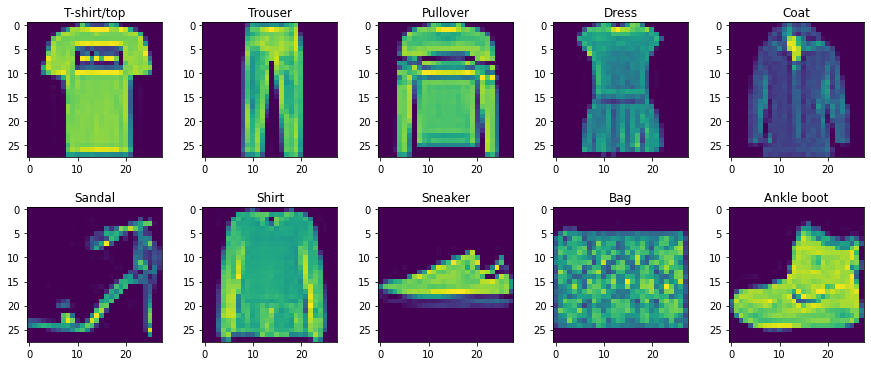

In [42]:
# Utility functions

def flatten(arr):
    arr = arr.reshape(arr.shape[0], -1)
    return arr

def plot_labels(data, labels, flatten=False):

    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    uniq_labels = np.unique(labels)

    fig, ax = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = ax.reshape(-1)

    for i, label in enumerate(uniq_labels):

        img = data[np.where(labels == label)[0][0]]

        ax[i].set_title(class_names[label])
        
        if flatten:
            img = img.reshape(28, 28)

        ax[i].imshow(img)
    
    plt.show()

plot_labels(train_images, train_labels)

In [56]:
train_images = flatten(train_images)
test_images = flatten(test_images)

train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, shuffle=True)

In [44]:
train_labels.shape, val_labels.shape

((54000,), (6000,))

In [59]:
model = NeuralNet([FC(784, 64), RelU(), FC(64, 10)])
optimizer = SGD()
loss = CrossEntropyLossFromLogits()

model.compile(loss, optimizer)
model.fit(train_images, train_labels, val_images, val_labels, batch_size=128, epochs=5)

Epoch: 1 Train Loss: 0.6969673123935638 Train Accuracy: 0.7608962423832092 Val Loss: 0.5408395596427503 Val Accuracy: 0.8132836246200608
Epoch: 2 Train Loss: 0.4863288292283048 Train Accuracy: 0.8286327860528098 Val Loss: 0.4820742308863707 Val Accuracy: 0.8324468085106383
Epoch: 3 Train Loss: 0.43530913861402126 Train Accuracy: 0.8442577860528098 Val Loss: 0.4537590006356489 Val Accuracy: 0.8406867401215805
Epoch: 4 Train Loss: 0.40582520843351383 Train Accuracy: 0.8550905551794177 Val Loss: 0.4287132329678722 Val Accuracy: 0.849354103343465
Epoch: 5 Train Loss: 0.3845829992215277 Train Accuracy: 0.8619218644211238 Val Loss: 0.412609811555659 Val Accuracy: 0.8535571808510638

Model trained successfully!


In [66]:
def get_activation(name="relu"):
    if name == "relu":
        return RelU()
    elif name == "tanh":
        return Tanh()
    elif name == "sigmoid":
        return Sigmoid()

def get_optimizer(name="sgd", lr):
    # make similar function as above
    pass

def create_layers(n_layers, layer_size, activation, weight_decay, init_method):

    layers = []
    layers.extend([FC(784,layer_size, weight_decay, init_method), get_activation(activation)])
    
    for _ in range(n_layers-1):
        layers.extend([FC(layer_size, layer_size, weight_decay, init_method), get_activation(activation)])
    
    layers.append(FC(layer_size, 10, weight_decay, init_method))

    return layers


def train():

    config_defaults = {
        'n_layers': 3,
        'layer_size': 32,
        'weight_decay': 0,
        'lr': 1e-3,
        'optimizer': 'sgd',
        'batch_size': 32,
        'init_method': 'random',
        'activation': 'relu'
        'epochs': 5
    }

    wandb.init(config=config_defaults, magic=True)

    fashion_mnist = tf.keras.datasets.fashion_mnist
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    train_images = flatten(train_images / 255.0)
    test_images = flatten(test_images / 255.0)   

    train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, shuffle=True)

    model = NeuralNet(create_layers(wandb.config.n_layers, 
                                    wandb.config.layer_size, 
                                    wandb.config.activation, 
                                    wandb.config.weight_decay,
                                    wandb.config.init_method))

    
    model.compile(loss=CrossEntropyLossFromLogits(), optimizer=get_optimizer(wandb.config.optimizer, wandb.config.lr))
    
    model.fit(train_images, train_labels, val_images, val_labels, batch_size=wandb.config.batch_size, epochs=wandb.config.epochs)

   


In [67]:
create_layers(3, 32, "relu", 1e-3, "random")